In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [30]:
df =pd.read_csv('/content/drive/MyDrive/dataFile/synthetic_dataset.csv')
print(df)

     feature1  feature2  feature3  feature4  target
0    1.248357  2.357787  2.074098  1.279545       1
1    0.930868  2.560785  1.367035  2.590535       0
2    1.323844  3.083051  0.281877  1.403255       3
3    1.761515  3.053802  4.323612  1.327312       1
4    0.882923  0.622331  4.064505  1.328532       0
..        ...       ...       ...       ...     ...
195  1.192659  1.530824  0.906165  1.974862       2
196  0.558071  0.286865  0.332481  2.789104       2
197  1.076863  3.353872  3.705603  2.599711       0
198  1.029104  1.885460  2.872366  1.850427       1
199  0.428515  3.237816  4.209144  1.044939       2

[200 rows x 5 columns]


In [31]:
features = ['feature1','feature2','feature3','feature4']
X = df[features]
Y = df['target'].values.reshape(-1,1)

In [32]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 4
        hiddenLayer1Neurons = 10
        hiddenLayer2Neurons = 8
        outLayerNeurons = 1

        self.learning_rate = 0.2
        self.W_HI = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_HI1 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_OH = np.random.randn(hiddenLayer2Neurons, outLayerNeurons)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def feedForward(self, X):
        self.input = X
        self.hidden_input = np.dot(X, self.W_HI)
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.hidden_input1 = np.dot(self.hidden_output, self.W_HI1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.output_input = np.dot(self.hidden_output1, self.W_OH)
        self.pred = self.sigmoid(self.output_input)
        return self.pred

    def backPropagation(self, Y):
        # Output layer error
        output_error = Y - self.pred
        output_delta = output_error * self.sigmoid(self.pred, der=True)

        # Hidden Layer 2 error
        hidden_error1 = output_delta.dot(self.W_OH.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, der=True)

        # Hidden Layer 1 error
        hidden_error0 = hidden_delta1.dot(self.W_HI1.T)
        hidden_delta0 = hidden_error0 * self.sigmoid(self.hidden_output, der=True)

        # Update weights
        self.W_OH += self.hidden_output1.T.dot(output_delta) * self.learning_rate
        self.W_HI1 += self.hidden_output.T.dot(hidden_delta1) * self.learning_rate
        self.W_HI += self.input.T.dot(hidden_delta0) * self.learning_rate

    def train(self, X, Y):
        self.feedForward(X)
        self.backPropagation(Y)


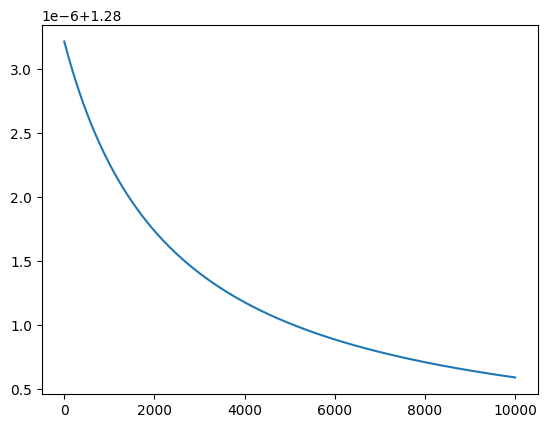

In [34]:
NN = NeuralNetwork()
err = []

for i in range(10000):
    NN.train(X, Y)
    err.append(np.mean(np.square(Y - NN.feedForward(X))))

plt.plot(err)

# New Section